# SVM Models for Azure VM Criticality

End-to-end notebook that trains linear and RBF SVMs to predict whether a VM request will be `critical`, using only the **23 arrival-time features** (no leakage from post-hoc CPU behavior). Each step below has a brief explainer.

## Imports and plotting style
Set up scientific Python stack, sklearn utilities, and a clean plotting style.

In [6]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import clone
from sklearn.compose import ColumnTransformer

# FIXED: separate these imports
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
)

from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer

warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 110


## Load the labeled dataset
Read the ML-ready Parquet table produced by preprocessing (see `README.md`). Confirm row counts per split and class balance so we know the positive rate.

In [7]:
CANDIDATE_PATHS = [
    Path("data_final/vm_request_table_with_split.parquet"),
    Path("../data_final/vm_request_table_with_split.parquet"),
]
for path in CANDIDATE_PATHS:
    if path.exists():
        DATA_PATH = path
        break
else:
    raise FileNotFoundError("Could not find vm_request_table_with_split.parquet from this notebook location.")

print(f"Using data file: {DATA_PATH}")
df = pd.read_parquet(DATA_PATH)

print(f"\nTotal rows: {len(df):,}")
print("Rows per split:\n", df["split"].value_counts())

critical_rate = df.groupby("split")["critical"].mean().rename("critical_rate")
print("\nCritical rate by split:\n", (critical_rate * 100).round(2).astype(str) + "%")


Using data file: ../data_final/vm_request_table_with_split.parquet

Total rows: 894,280
Rows per split:
 split
train    632426
test     131849
val      130005
Name: count, dtype: int64

Critical rate by split:
 split
test     32.37%
train    35.93%
val      30.29%
Name: critical_rate, dtype: object


## Select arrival-time features and create splits
Use only the 23 arrival-time predictors (timing, VM specs, tenant history) and keep the provided time-based train/val/test partitions via the `split` column. IDs and label/split are excluded from features.

In [8]:
ARRIVAL_FEATURES = [
    # timing
    "ts_vm_created",
    "day_idx",
    "hour_of_day",
    # vm config & deployment
    "vm_category",
    "vm_virtual_core_count",
    "vm_memory_gb",
    "vm_mem_per_core",
    "deployment_size",
    "log_deployment_size",
    # tenant info at first activity
    "ts_first_vm_created",
    "count_vms_created",
    "sub_first_day",
    "sub_first_hour",
    # tenant history before this VM
    "hist_n_vms",
    "hist_n_critical",
    "hist_has_past",
    "hist_critical_frac",
    "hist_lifetime_mean",
    "hist_lifetime_std",
    "hist_cpu_mean_mean",
    "hist_p95_mean",
    "hist_frac_gt60_mean",
    "hist_day_night_ratio_mean",
]
TARGET = "critical"

train_df = df[df["split"] == "train"].copy()
val_df = df[df["split"] == "val"].copy()
test_df = df[df["split"] == "test"].copy()

X_train, y_train = train_df[ARRIVAL_FEATURES], train_df[TARGET]
X_val, y_val = val_df[ARRIVAL_FEATURES], val_df[TARGET]
X_test, y_test = test_df[ARRIVAL_FEATURES], test_df[TARGET]

print(f"Train rows: {len(train_df):,} | Val rows: {len(val_df):,} | Test rows: {len(test_df):,}")


Train rows: 632,426 | Val rows: 130,005 | Test rows: 131,849


## Preprocess features and helper for evaluation
One-hot encode the lone categorical column (`vm_category`) and standardize numeric features. Define a reusable helper to report metrics and visualize confusion matrix + ROC curve.

In [9]:
categorical_features = ["vm_category"]
numeric_features = [col for col in ARRIVAL_FEATURES if col not in categorical_features]

numeric_cols = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop",
)

def build_svm(C: float = 1.0) -> Pipeline:
    svm = LinearSVC(C=C, class_weight="balanced", max_iter=5000)
    return Pipeline([
        ("preprocess", clone(preprocessor)),
        ("svm", svm),
    ])

def evaluate_model(model: Pipeline, X, y, label: str = "Validation") -> None:
    y_pred = model.predict(X)
    if hasattr(model.named_steps['svm'], 'predict_proba'):
        y_score = model.predict_proba(X)[:, 1]
    else:
        y_score = model.decision_function(X)

    cm = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=["Actual: not critical", "Actual: critical"],
        columns=["Pred: not critical", "Pred: critical"],
    )

    print(f"\n{label} confusion matrix (counts):")
    print(cm_df.to_string())
    print(f"\n{label} classification report:")
    print(classification_report(y, y_pred, digits=3))

    precision, recall, _ = precision_recall_curve(y, y_score)
    pr_auc = auc(recall, precision)
    roc_auc = roc_auc_score(y, y_score)

    fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
    axes[0].set_title(f"{label} Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    RocCurveDisplay.from_predictions(y, y_score, ax=axes[1], name=label)
    axes[1].set_title(f"{label} ROC Curve")

    PrecisionRecallDisplay.from_predictions(y, y_score, ax=axes[2], name=label)
    axes[2].set_title(f"{label} Precision-Recall Curve")
    plt.tight_layout()
    plt.show()

    print(f"{label} ROC AUC: {roc_auc:.3f} | PR AUC: {pr_auc:.3f}")
def get_feature_names(model: Pipeline):
    return model.named_steps['preprocess'].get_feature_names_out()

def plot_linear_feature_importance(model: Pipeline, top_n: int = 15):
    feature_names = get_feature_names(model)
    coefs = model.named_steps['svm'].coef_[0]
    top_idx = np.argsort(np.abs(coefs))[::-1][:top_n]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=coefs[top_idx], y=np.array(feature_names)[top_idx], orient='h')
    plt.title('Top linear SVM feature weights')
    plt.xlabel('Coefficient')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

def plot_permutation_feature_importance(model: Pipeline, X, y, top_n: int = 15):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    feature_names = get_feature_names(model)
    importances = result.importances_mean
    top_idx = np.argsort(importances)[::-1][:top_n]
    plt.figure(figsize=(8, 6))
    sns.barplot(x=importances[top_idx], y=np.array(feature_names)[top_idx], orient='h')
    plt.title('Top permutation importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


## Linear SVM (vanilla)
Train a linear decision boundary with balanced class weights, then evaluate on validation and test splits with metrics and plots.


Validation (Linear SVM) confusion matrix (counts):
                      Pred: not critical  Pred: critical
Actual: not critical               83228            7400
Actual: critical                   17158           22219

Validation (Linear SVM) classification report:
              precision    recall  f1-score   support

           0      0.829     0.918     0.871     90628
           1      0.750     0.564     0.644     39377

    accuracy                          0.811    130005
   macro avg      0.790     0.741     0.758    130005
weighted avg      0.805     0.811     0.803    130005



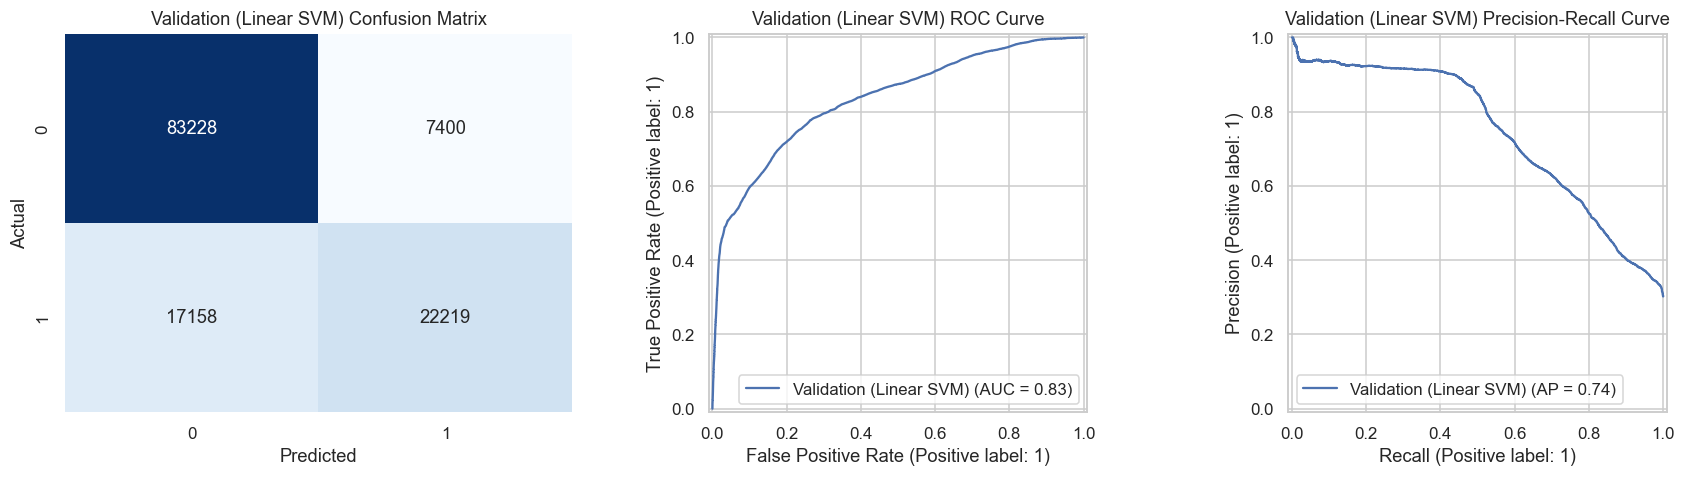

Validation (Linear SVM) ROC AUC: 0.834 | PR AUC: 0.744

Test (Linear SVM) confusion matrix (counts):
                      Pred: not critical  Pred: critical
Actual: not critical               78767           10406
Actual: critical                   18319           24357

Test (Linear SVM) classification report:
              precision    recall  f1-score   support

           0      0.811     0.883     0.846     89173
           1      0.701     0.571     0.629     42676

    accuracy                          0.782    131849
   macro avg      0.756     0.727     0.737    131849
weighted avg      0.775     0.782     0.776    131849



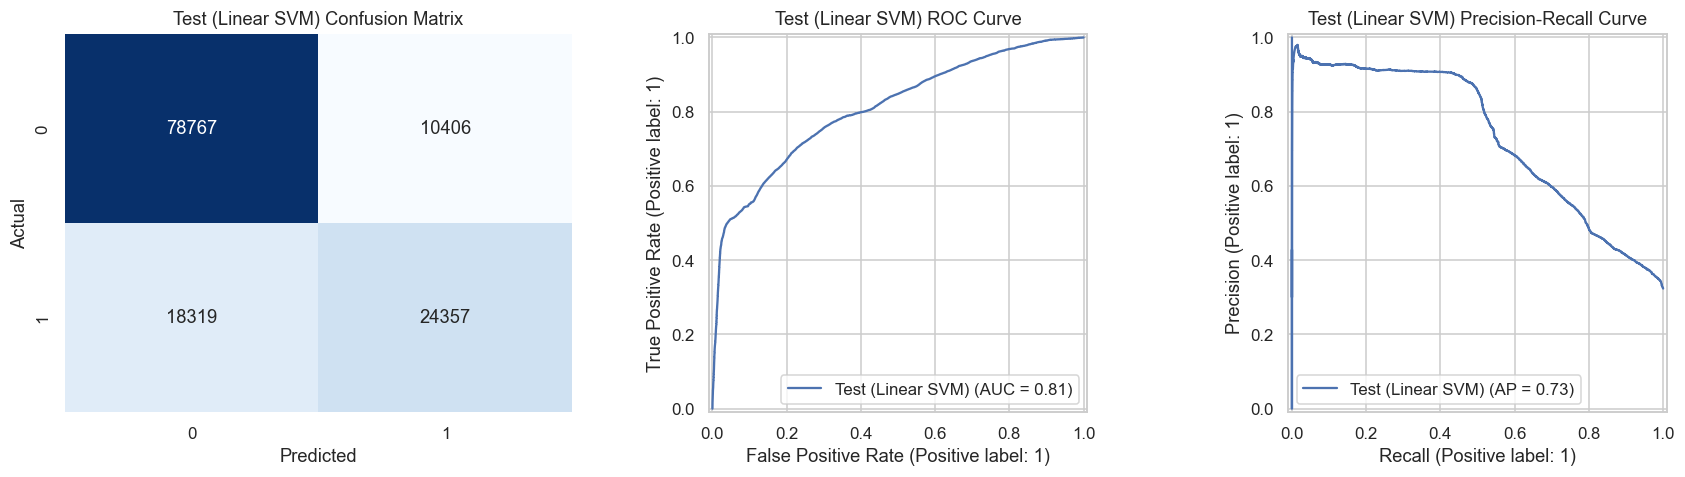

Test (Linear SVM) ROC AUC: 0.811 | PR AUC: 0.733


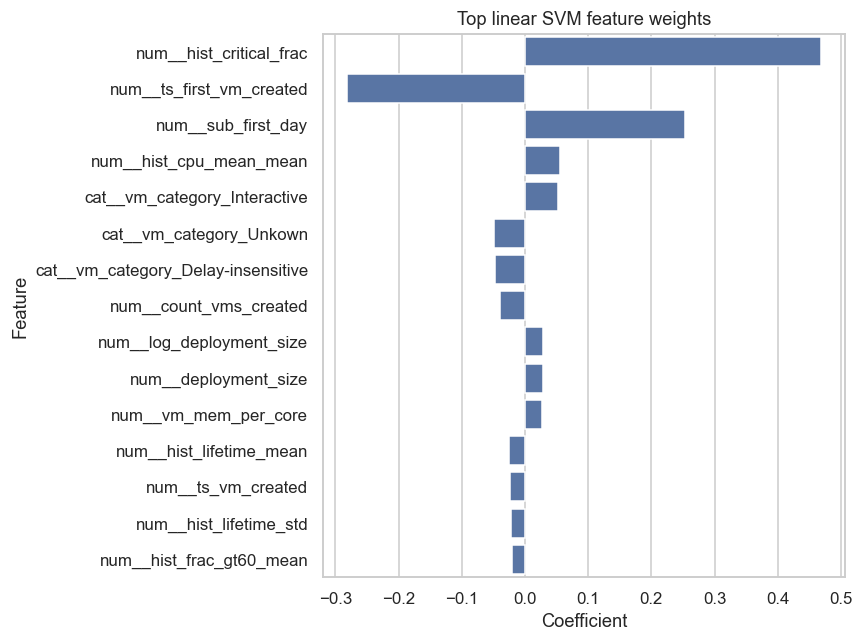

In [10]:
linear_svm = build_svm(C=1.0)

linear_svm.fit(X_train, y_train)

evaluate_model(linear_svm, X_val, y_val, label="Validation (Linear SVM)")
evaluate_model(linear_svm, X_test, y_test, label="Test (Linear SVM)")

plot_linear_feature_importance(linear_svm, top_n=15)
